In [1]:
import numpy as np

# Load data from digits_8features_data.npz
loaded_data = np.load('../data/digits_8features_data.npz')

# Extract the data (300 train, 100 val, 100 test)
X_train = loaded_data['X_train']
y_train = loaded_data['y_train']
X_val = loaded_data['X_val']
y_val = loaded_data['y_val']
X_test = loaded_data['X_test']
y_test = loaded_data['y_test']

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (300, 8), y_train shape: (300,)
X_val shape: (100, 8), y_val shape: (100,)
X_test shape: (100, 8), y_test shape: (100,)


In [2]:
# Load tqfm from result_optimizer folder (SPSA only)
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import pickle

# Load tqfm from result_optimizer folder - SPSA optimizer only
results_dir = '../result_optimizer'

# List all files in the results directory - filter for SPSA only
files = [f for f in os.listdir(results_dir) if f.endswith('.pkl') and 'SPSA' in f]

# Load all tqfm objects
tqfm_list = []
for file in sorted(files):  # Sort for consistent ordering
	with open(os.path.join(results_dir, file), 'rb') as f:
		tqfm = pickle.load(f)
		tqfm_list.append(tqfm)

print(f"Loaded {len(tqfm_list)} TQFM models (SPSA optimizer) from {results_dir}")
print(f"Files: {files[:3]}..." if len(files) > 3 else f"Files: {files}")

Loaded 5 TQFM models (SPSA optimizer) from ../result_optimizer
Files: ['tqfm_digits_depth2_ansatzRealAmplitudes_optimizerSPSA_iter100000_run1.pkl', 'tqfm_digits_depth2_ansatzRealAmplitudes_optimizerSPSA_iter100000_run2.pkl', 'tqfm_digits_depth2_ansatzRealAmplitudes_optimizerSPSA_iter100000_run3.pkl']...


In [3]:
# Find the TQFM model with the lowest final loss
min_loss = float('inf')
best_tqfm_idx = -1

for i, tqfm in enumerate(tqfm_list):
	if hasattr(tqfm, 'loss_history') and tqfm.loss_history:
		final_loss = tqfm.loss_history[-1]
		if final_loss < min_loss:
			min_loss = final_loss
			best_tqfm_idx = i

best_tqfm = tqfm_list[best_tqfm_idx]
print(f"Best TQFM model: Run {best_tqfm_idx + 1}")
print(f"Lowest final loss: {min_loss}")

Best TQFM model: Run 1
Lowest final loss: 0.7809700392771324


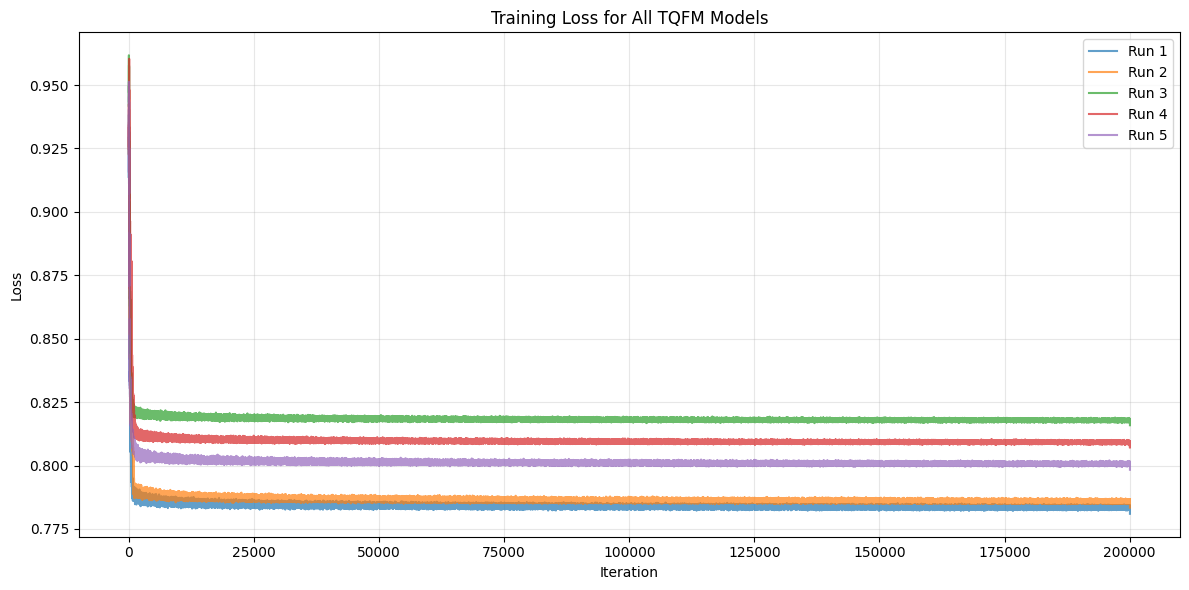

In [4]:
import matplotlib.pyplot as plt

# Plot the loss for all TQFM models
plt.figure(figsize=(12, 6))

for i, tqfm in enumerate(tqfm_list):
	if hasattr(tqfm, 'loss_history') and tqfm.loss_history:
		plt.plot(tqfm.loss_history, label=f'Run {i+1}', alpha=0.7)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss for All TQFM Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Load kernel matrices from result_optimizer folder (SPSA only)
kernel_dir = '../result_optimizer'

# List all kernel files - filter for SPSA only
kernel_files = [f for f in os.listdir(kernel_dir) if f.startswith('kernels_') and f.endswith('.npz') and 'SPSA' in f]

# Load all kernel matrices
kernels_list = []
for kernel_file in sorted(kernel_files):  # Sort for consistent ordering
	kernel_path = os.path.join(kernel_dir, kernel_file)
	kernels = np.load(kernel_path)
	kernels_list.append({
		'filename': kernel_file,
		'kernel_before': kernels['kernel_before'],
		'kernel_after': kernels['kernel_after'],
		'kernel_val': kernels['kernel_val'],
		'kernel_test': kernels['kernel_test']
	})

print(f"Loaded {len(kernels_list)} kernel matrix sets (SPSA optimizer) from {kernel_dir}")
print(f"\nKernel shapes (first file):")
print(f"  kernel_after (train): {kernels_list[0]['kernel_after'].shape}")
print(f"  kernel_val: {kernels_list[0]['kernel_val'].shape}")
print(f"  kernel_test: {kernels_list[0]['kernel_test'].shape}")

Loaded 5 kernel matrix sets (SPSA optimizer) from ../result_optimizer

Kernel shapes (first file):
  kernel_after (train): (300, 300)
  kernel_val: (100, 300)
  kernel_test: (100, 300)


In [6]:
# Calculate separability ratio and accuracy for all runs
from src.utils import class_similarity, calculate_accuracy

results = []

for i, (tqfm, kernels) in enumerate(zip(tqfm_list, kernels_list)):
	# Get kernels
	K_train = kernels['kernel_after']
	K_val = kernels['kernel_val']
	K_test = kernels['kernel_test']
	
	# Calculate separability ratio
	_, _, _, sep_ratio = class_similarity(K_train, y_train)
	
	# Calculate accuracies with optimal C
	val_acc, test_acc, best_C = calculate_accuracy(
		K_train, K_val, K_test, y_train, y_val, y_test
	)
	
	# Get final loss
	final_loss = tqfm.loss_history[-1] if hasattr(tqfm, 'loss_history') and tqfm.loss_history else None
	
	results.append({
		'run': i + 1,
		'final_loss': final_loss,
		'separability_ratio': sep_ratio,
		'val_accuracy': val_acc,
		'test_accuracy': test_acc,
	})

# Display results
import pandas as pd
df_results = pd.DataFrame(results)
print("\n" + "="*90)
print("SPSA Optimizer - All Runs Results")
print("="*90)
print(df_results.to_string(index=False))
print("="*90)

# Find best run
best_run_idx = df_results['final_loss'].idxmin()
print(f"\n🏆 Best Run (Lowest Loss): Run {df_results.loc[best_run_idx, 'run']}")
print(f"   Final Loss: {df_results.loc[best_run_idx, 'final_loss']:.6f}")
print(f"   Separability Ratio: {df_results.loc[best_run_idx, 'separability_ratio']:.6f}")
print(f"   Test Accuracy: {df_results.loc[best_run_idx, 'test_accuracy']:.4f}")


SPSA Optimizer - All Runs Results
 run  final_loss  separability_ratio  val_accuracy  test_accuracy
   1    0.780970            5.951808          0.92           0.93
   2    0.783417            7.350870          0.91           0.92
   3    0.815893            6.957870          0.93           0.92
   4    0.807182            4.828484          0.93           0.93
   5    0.798332            6.545860          0.90           0.93

🏆 Best Run (Lowest Loss): Run 1
   Final Loss: 0.780970
   Separability Ratio: 5.951808
   Test Accuracy: 0.9300


In [7]:
from sklearn.metrics.pairwise import rbf_kernel
from src.utils import calculate_accuracy

rbf_K_train = rbf_kernel(X_train)
rbf_K_val = rbf_kernel(X_val, X_train)
rbf_K_test = rbf_kernel(X_test, X_train)

classical_val_acc, classical_test_acc, _ = calculate_accuracy(
    rbf_K_train, rbf_K_val, rbf_K_test,
    y_train, y_val, y_test
)
print("Val acc | Test acc")
print(f"{classical_val_acc} | {classical_test_acc}")

Val acc | Test acc
0.94 | 0.95
